Flavio Giobergia  
*Research Bites @ Data Science Lab*

### Word embeddings demo

To load and use word embeddings, we will be using [gensim](https://radimrehurek.com/gensim/).

In [1]:
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

Here, we load a word embedding using `load_word2vec_format()`, a method from the `KeyedVectors` class.

`KeyedVectors` is a class that manages embeddings such as word2vec, in which we have a key (word) used for look-up and an associated vector. More about that in the [official documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

The "word2vec format" (used in [`load_word2vec_format()`](https://radimrehurek.com/gensim/models/keyedvectors.html)) is a simple format in which the first line is:

```
N M
```

`N` is the number of rows (or words) and `M` is the number of columns (or dimensions). 
Then, `N` lines follow, each one as shown below:

```
word_i val1 val2 ... valM
```
Where `(val1, val2, ... valM)` is the M-dimensional vector that encodes `word_i`. 


The file that is being loaded here is `wiki.en.vec`, a word embedding trained with [fastText](https://fasttext.cc/), a "newer" version of word2vec. All fastText embeddings are available from the website (as well as all relevant references).

In [75]:
# Download vectors from https://fasttext.cc/docs/en/pretrained-vectors.html
#wv = KeyedVectors.load_word2vec_format("wiki.en.vec")
#wv = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")
wv = KeyedVectors.load_word2vec_format("crawl-300d-2M-subword.vec")

The `vocab` attribute is a dictionary of (key, vector) pairs. In this case, we can see that this dictionary contains 2,519,370 words.

In [76]:
len(wv)

2000000

For each word, we can extract the associated vector using either `wv.vocab["word"]` (but that returns a Vector object), or using the `get_vector()` method of `KeyedVectors` (which returns a very convenient numpy array).

In this case, the vectors are 300-dimensional (as shown below).

In [77]:
type(wv.get_vector("italy")), wv.get_vector("italy").shape

(numpy.ndarray, (300,))

We can now extract vectors for all the words we want (as long as those words are included in the vocabulary!) and we can have some fun with vector operations. 

For example, we can try the classic "rome" - "italy" + "france", which should hopefully return "paris". To be more precise, if the vector for the word *word* is $v_{word}$, we are actually computing $v_{rome} - v_{italy} + v_{france}$ and we should get $v_{paris}$, since we are doing the operations on vectors, not on symbols. But, since there is a 1:1 mapping between symbols and vectors, we will use the less cumbersome notation "rome" - "italy" + "france" = "paris". 

Now, to be more precise, when we write "=" we actually mean "is close to". This means that the vector for "rome" - "italy" + "france" is actually some vectors that is not associated with any word (in `wv.vocab`). However, if we search all known words, we find that the closest one to our (latent) vector is indeed the vector for "paris". 

This is exactly what the `similar_by_vector()` method does: it receives a vector as input, and returns the closest known words (by specifying `topn=1`, only the "first" closest word is returned). 

The output of `similar_by_vector` is a list of (word, similarity) pairs (the list contains `topn` elements). The similarity is returned in terms of cosine similarity between the input vector and the vector for the returned word.

In [78]:
# rome - italy + france?

vec_rome = wv.get_vector("rome")
vec_italy = wv.get_vector("italy")
vec_france = wv.get_vector("france")
wv.similar_by_vector(vec_rome - vec_italy + vec_france, topn=1)

[('rome', 0.8357623219490051)]

In [79]:
# “king − man + woman ≈ queen”
vec_queen = wv.get_vector("queen")
vec_king = wv.get_vector("king")
vec_woman = wv.get_vector("woman")
vec_feminine = wv.get_vector("feminine")
vec_royal = wv.get_vector("royal")
vec_boy = wv.get_vector("boy")
vec_prince = wv.get_vector("prince")
vec_man = wv.get_vector("man")
vec_macho = wv.get_vector("macho")
vec_manly = wv.get_vector("manly")
vec_adult = wv.get_vector("adult")
vec_crown = wv.get_vector("crown")

wv.similar_by_vector(vec_king - vec_man + vec_woman , topn=3)

[('king', 0.8437220454216003),
 ('queen', 0.7575955986976624),
 ('kings', 0.6283357739448547)]

In [81]:
wv.similar_by_vector(vec_king - vec_man + vec_boy , topn=3)

[('king', 0.780688464641571),
 ('boy', 0.6730770468711853),
 ('prince', 0.6204152703285217)]

In [82]:
wv.similar_by_vector(vec_king - vec_man + vec_boy , topn=3)

[('king', 0.780688464641571),
 ('boy', 0.6730770468711853),
 ('prince', 0.6204152703285217)]

In [83]:
wv.similar_by_vector(vec_queen - vec_woman + vec_man, topn=3)

[('queen', 0.8591006994247437),
 ('king', 0.803173303604126),
 ('queens', 0.6978293061256409)]

We can now try our hand at something slightly more interesting (and more visual). We can get the vectors for a bunch of countries and their capital cities. For those words, we can extract their vectors and extract the first two principal components (i.e. the 2 components that retain the most variance for those points) using a PCA. We can now visualize those points (and the vectors that maps from the countries to the capitals) on a 2D plot.

In [84]:
countries = ["china",   "russia", "japan", "turkey", "poland", "germany", "france", "italy", "greece", "spain",  "portugal"]
capitals  = ["beijing", "moscow", "tokyo", "ankara", "warsaw", "berlin",  "paris",  "rome",  "athens", "madrid", "lisbon"]

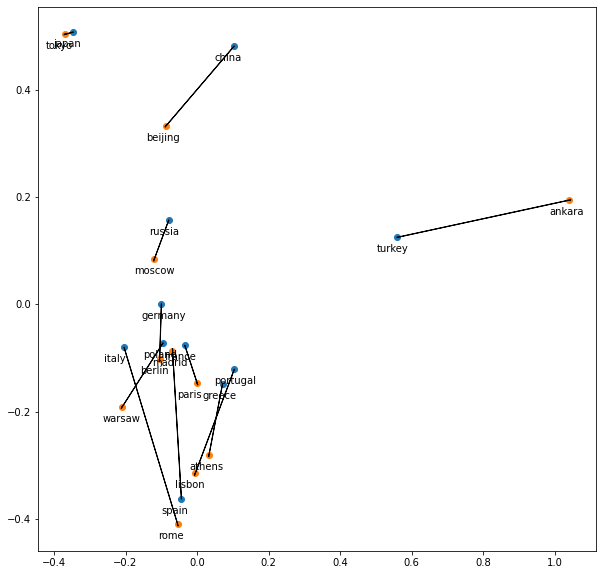

In [85]:


def plot_pairs(wv, a, b):
    
    ndx_a = [ wv.key_to_index[a_i] for a_i in a ]
    ndx_b = [ wv.key_to_index[b_i] for b_i in b ]
    
    pca = PCA(2)
    wv2 = pca.fit_transform(wv.vectors[ndx_a + ndx_b])
    
    wv_a = wv2[:len(ndx_a)]
    wv_b = wv2[len(ndx_a):]
    
    plt.figure(figsize=(10,10))
    plt.scatter(wv_a[:,0], wv_a[:,1])
    plt.scatter(wv_b[:,0], wv_b[:,1])
    
    for i, (p_a, p_b) in enumerate(zip(a,b)):
        plt.annotate(p_a, wv_a[i], xytext=(-20,-15), textcoords="offset pixels")
        plt.annotate(p_b, wv_b[i], xytext=(-20,-15), textcoords="offset pixels")
        
    for i in range(len(wv_a)):
        plt.arrow(wv_a[i,0], wv_a[i,1], wv_b[i,0]-wv_a[i,0], wv_b[i,1]-wv_a[i,1], shape="left")

plot_pairs(wv, countries, capitals)

We can see that capitals and countries are well separated. Additionally, the vector that maps each country to each capital (i.e. *country* - *capital*) is approximately the same. That vector "encodes" the concept of "being a capital of". Keep in mind that this very clean visualization is only possible because we are limiting the visualization (and the PCA) to a small subset of points (words). If we were to project all words, we would have obtained a much less interpretable result. 

This visualization, by the way, is very similar to the one presented in [1].

Finally, let's conclude with what is probably the most famous example of word2vec: king - man + woman = queen. 

In [21]:
# king - man + woman = king??
vec_king = wv.get_vector("king")
vec_man = wv.get_vector("man")
vec_woman = wv.get_vector("woman")
wv.similar_by_vector(vec_king - vec_man + vec_woman, topn=5)

[('king', 0.7955734729766846),
 ('queen', 0.680290162563324),
 ('princess', 0.5975186824798584),
 ('regnant', 0.5888891220092773),
 ('princesses', 0.5710145235061646)]

It turns out that word2vec actually predicts "king" as the closest word to king - man + woman! 

There is not a perfect explanation for this "misprediction", if not that word embeddings are not an all-seeing god the knows everything (as one might believe when they first hear about this kind of vector operations). 

In this case, "king" - "man" + "woman" is some vector that is quite close to both "king" and "queen" (though slightly closer to "king"). Also, notice how "king" and "queen" are also close to one another. Indeed, "queen" is the second most similar word to king (after "kings"). 

In [22]:
wv.similar_by_vector(vec_king, topn=10)

[('king', 1.0),
 ('kings', 0.6761605143547058),
 ('queen', 0.6493092179298401),
 ('monarch', 0.6260097026824951),
 ('kingship', 0.5977715253829956),
 ('#king', 0.5955577492713928),
 ('throne', 0.5953187346458435),
 ('king/king', 0.5743653774261475),
 ('kingly', 0.5734266042709351),
 ('reign', 0.569341242313385)]

One may now believe that, therefore, the operation -"man"+"woman" does not do much (and indeed maps "king" back to "king"). However, notice how other vectors close to "king"-"man"+"woman" are also related to the feminine version of king ("queen", "princess", "princesses"), whereas "king"'s closest words are related to the concept of kingship (indeed, "kingship" is one of those words). This means that "king"-"man"+"woman" is indeed moving towards a "more feminine" (for lack of a better definition) region.

So, how did the "king" - "man" + "woman" = "queen" example become so famous? 

The example was actually mentioned in the original paper for word2vec [1].

Also in that paper, we find the following statement:
> The task consists of analogies such as “Germany” : “Berlin” :: “France” : ?, which are solved by finding a vector x such that vec(x) is closest to vec(“Berlin”) - vec(“Germany”) + vec(“France”) according to the cosine distance **(we discard the input words from the search)**

In bold is the assumption that makes it so that "king" - "man" + "woman" is actually closest to "queen" (i.e. "king" is not considered, as it was part of the input). 

This little trick has been at the center of many heated discussions. In particular, word2vec has been accused of being biased: in [2] you can find an interesting discussion on the matter (as well as the fact that most of this so-called "bias" is due to this trick of excluding input words when computing the output). 

This trick has also been included in gensim: the method `most_similar()` takes as input a list of positive and negative words and computes the most similar word to the resulting vector (obtained as $ \sum_i v_{pos,i} - \sum_i v_{neg,i}$), but excludes input words from the output (as shown in the source code on [github](https://github.com/RaRe-Technologies/gensim/blob/eff2faf0eca0da7ad41d20e17b5ef46c11874148/gensim/models/keyedvectors.py#L782)). Indeed, if we try to use `most_similar(positive=["king","man"], negative=["woman"])`, we get "queen"!

All in all, the famous "king" example conveys the intuition behind word embeddings (i.e. we can now do operations with words, and (sometimes) the results make sense!) very easily, but we should probably stay away from all the unnecessary hype that has been built around it. Word embeddings are a great tool, not The Oracle!

### References 

[1] Mikolov, Tomas, et al. "Distributed representations of words and phrases and their compositionality." Advances in neural information processing systems 26 (2013): 3111-3119.  
[2] Nissim, Malvina, Rik van Noord, and Rob van der Goot. "Fair is better than sensational: Man is to doctor as woman is to doctor." (2020): 1-11.

In [59]:
es = KeyedVectors.load_word2vec_format("wiki.es.vec")

In [60]:
# “king − man + woman ≈ queen”
vec_queen = wv.get_vector("reina")
vec_king = wv.get_vector("rey")
vec_woman = wv.get_vector("mujer")
vec_feminine = wv.get_vector("feminine")
vec_royal = wv.get_vector("royal")
vec_boy = wv.get_vector("boy")
vec_prince = wv.get_vector("prince")
vec_man = wv.get_vector("hombre")
vec_macho = wv.get_vector("macho")
vec_manly = wv.get_vector("manly")
vec_adult = wv.get_vector("adult")
vec_crown = wv.get_vector("crown")

In [65]:
wv.similar_by_vector(vec_queen - vec_woman + vec_macho , topn=20)

[('reina', 0.5513908863067627),
 ('macho', 0.549350917339325),
 ('katsuharu', 0.38748690485954285),
 ('rikishi', 0.3823675215244293),
 ('rikishiman', 0.38038456439971924),
 ('briscoes', 0.37671253085136414),
 ('takanonami', 0.37483057379722595),
 ('sakato', 0.36977338790893555),
 ('iori', 0.36885419487953186),
 ('takeru', 0.36864253878593445),
 ('matsuhara', 0.3684028685092926),
 ('kazuchika', 0.36610937118530273),
 ('masato', 0.3657550513744354),
 ('brawling', 0.3652316629886627),
 ('tomacho', 0.36433300375938416),
 ('kumaga', 0.3632347583770752),
 ('stablemates', 0.36284586787223816),
 ('tajiri', 0.3627178370952606),
 ('satozaki', 0.362650066614151),
 ('gigano', 0.36246809363365173)]

In [23]:
import session_info
session_info.show(html=False)

-----
gensim              4.3.1
matplotlib          3.5.0
session_info        1.0.0
sklearn             1.2.1
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-40-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-04-22 22:06
